In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Extract EXIF Data from JPG Images (Code Junk & Testing)**

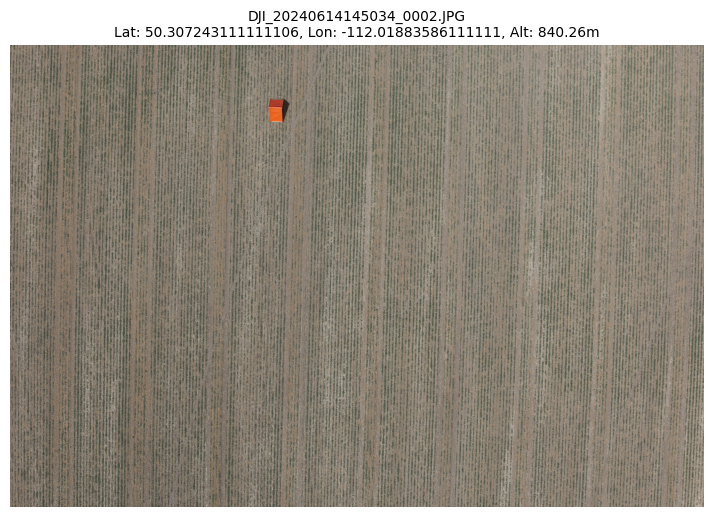

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

# Function to extract GPS metadata
def get_gps_coordinates(img_path):
    img = Image.open(img_path)
    exif_data = img._getexif()

    if not exif_data:
        return None, None, None

    gps_info = {}

    # Extract GPS data
    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)
        if tag_name == "GPSInfo":
            for key in value.keys():
                gps_tag = GPSTAGS.get(key, key)
                gps_info[gps_tag] = value[key]

    # Extract latitude and longitude
    def convert_to_degrees(value):
        d, m, s = value
        return d + (m / 60.0) + (s / 3600.0)

    if "GPSLatitude" in gps_info and "GPSLongitude" in gps_info:
        lat = convert_to_degrees(gps_info["GPSLatitude"])
        lon = convert_to_degrees(gps_info["GPSLongitude"])

        if gps_info["GPSLatitudeRef"] == "S":  # South latitudes are negative
            lat = -lat
        if gps_info["GPSLongitudeRef"] == "W":  # West longitudes are negative
            lon = -lon

        altitude = gps_info.get("GPSAltitude", "Unknown")
        return lat, lon, altitude

    return None, None, None

# Set the folder path
folder_path = "/content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/DJI_202406141446_024_Matt-1312-164"

# Get all JPG images sorted alphabetically
jpg_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')])

if jpg_files:
    # Read the first image (index 0 for the very first, 1 for second image if needed)
    first_image_path = os.path.join(folder_path, jpg_files[1])

    # Read and display the image
    image = cv2.imread(first_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract GPS data
    lat, lon, alt = get_gps_coordinates(first_image_path)

    # Display image with GPS metadata
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    title_text = f"{jpg_files[0]}\nLat: {lat}, Lon: {lon}, Alt: {alt}m"
    plt.title(title_text, fontsize=10)
    plt.axis("off")
    plt.show()
else:
    print("No JPG images found in the folder.")

# **GDAL Installation**

In [ ]:
!apt update && apt install -y gdal-bin python3-gdal

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,311 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,653 kB]
Hit:13 https://ppa.launchpadco

In [ ]:
!gdalinfo --version

GDAL 3.6.4, released 2023/04/17


# **Georeferncing - EXIF**

In [ ]:
import os
import math
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from osgeo import gdal, osr

def get_gps_coordinates(img_path):
    """
    Extract GPS metadata (lat, lon, altitude) from the EXIF tags of the image.
    Returns (latitude, longitude, altitude) in degrees / meters, or (None, None, None) if not found.
    Note: The altitude here is typically above sea level, not above ground level.
    """
    try:
        img = Image.open(img_path)
        exif_data = img._getexif()
        if not exif_data:
            return None, None, None

        gps_info = {}
        for tag_id, value in exif_data.items():
            tag_name = TAGS.get(tag_id, tag_id)
            if tag_name == "GPSInfo":
                for key in value.keys():
                    gps_tag = GPSTAGS.get(key, key)
                    gps_info[gps_tag] = value[key]

        def convert_to_degrees(dms_tuple):
            """
            Helper to convert (Degrees, Minutes, Seconds) tuples to float degrees.
            """
            d, m, s = dms_tuple
            return d + (m / 60.0) + (s / 3600.0)

        if "GPSLatitude" in gps_info and "GPSLongitude" in gps_info:
            # Convert lat/lon to float
            lat = convert_to_degrees(gps_info["GPSLatitude"])
            lon = convert_to_degrees(gps_info["GPSLongitude"])

            # Adjust for hemisphere
            if gps_info.get("GPSLatitudeRef") == "S":
                lat = -lat
            if gps_info.get("GPSLongitudeRef") == "W":
                lon = -lon

            # Altitude (if present, typically above sea level)
            alt = gps_info.get("GPSAltitude", None)
            if alt is not None:
                # Convert to float if it's a PIL/EXIF rational type
                # This handles IFDRational or other numeric types
                alt = float(alt)
            else:
                alt = None

            return lat, lon, alt

    except Exception as e:
        print(f"Error reading EXIF from {img_path}: {e}")

    return None, None, None

def calculate_pixel_size_deg(
    altitude_m,
    lat,
    sensor_width_mm,
    focal_length_mm,
    image_width_px
):
    """
    Calculate:
      - GSD (meters/pixel)
      - pixel size in degrees (latitude)
      - pixel size in degrees (longitude)
    based on:
      - altitude (meters, above ground)
      - camera params: sensor width (mm), focal length (mm), image width (px)
      - latitude (for converting meters to degrees of longitude)
    """
    # 1) Ground Sampling Distance (GSD) in meters/pixel:
    #    GSD = (altitude * sensor_width) / (focal_length * image_width)
    gsd_m = (altitude_m * sensor_width_mm) / (focal_length_mm * image_width_px)

    # 2) Convert GSD (m/pixel) to degrees/pixel.
    #    ~111,320 meters per degree latitude
    #    ~111,320 * cos(lat) meters per degree longitude
    #    If lat is None, default to 0.0 (equator)
    if lat is None:
        lat = 0.0

    pixel_size_deg_lat = gsd_m / 111320.0
    pixel_size_deg_lon = gsd_m / (111320.0 * math.cos(math.radians(lat)))

    return gsd_m, pixel_size_deg_lat, pixel_size_deg_lon

def georeference_jpg(
    input_jpg,
    output_tif,
    lat,
    lon,
    pixel_size_deg_lat,
    pixel_size_deg_lon
):
    """
    Convert a .jpg to a georeferenced .tif using GDAL.

    :param input_jpg: Path to the input JPG
    :param output_tif: Path to the output GeoTIFF
    :param lat: Center latitude of the image
    :param lon: Center longitude of the image
    :param pixel_size_deg_lat: Pixel size in degrees (north-south)
    :param pixel_size_deg_lon: Pixel size in degrees (east-west)
    """
    ds = gdal.Open(input_jpg)
    if ds is None:
        print(f"[Error] Could not open {input_jpg} with GDAL.")
        return

    driver = gdal.GetDriverByName('GTiff')
    if not driver:
        print("[Error] GTiff driver not available.")
        return

    # Create the GeoTIFF by copying the existing raster data
    out_ds = driver.CreateCopy(output_tif, ds, strict=0)
    if not out_ds:
        print(f"[Error] Could not create {output_tif}")
        return

    # Use EPSG:4326 (WGS84)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    out_ds.SetProjection(srs.ExportToWkt())

    width = ds.RasterXSize
    height = ds.RasterYSize

    # The provided lat/lon is the center of the image
    # Shift for top-left corner (origin) by half width/height in pixels
    top_left_lon = lon - (width / 2.0) * pixel_size_deg_lon
    top_left_lat = lat + (height / 2.0) * pixel_size_deg_lat

    # GeoTransform: [ top_left_long, pixel_width, 0, top_left_lat, 0, -pixel_height ]
    geotransform = [
        top_left_lon,
        pixel_size_deg_lon,  # East-west pixel size
        0,
        top_left_lat,
        0,
        -pixel_size_deg_lat  # Negative because latitude decreases downward
    ]
    out_ds.SetGeoTransform(geotransform)

    out_ds.FlushCache()
    out_ds = None
    ds = None

    print(f"[OK] Created georeferenced file: {output_tif}")

def main():
    # ----------------------------------------------------------------------
    SENSOR_WIDTH_MM = 35.8   # e.g., for Zenmuse P1 (full-frame)
    FOCAL_LENGTH_MM = 35.0   # e.g., 35mm lens
    IMAGE_WIDTH_PX  = 8192   # typical Zenmuse P1 image width

    # Local ground elevation in meters above sea level
    LOCAL_GROUND_ELEVATION = 761.0
    # ----------------------------------------------------------------------

    folder_path = "/content/drive/MyDrive/DJI_DroneData/DJI_DroneImages/DJI_024"
    out_folder = "/content/geotiffs_exif_024_1to15.zip"
    os.makedirs(out_folder, exist_ok=True)

    # Get the sorted list of JPG files
    image_files = sorted(
        f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')
    )

    if not image_files:
        print("[Warning] No JPG images found in the folder!")
        return

    for image_file in image_files[:15]:
        img_path = os.path.join(folder_path, image_file)

        # Extract GPS (lat, lon, alt) from image (alt is above sea level)
        lat, lon, alt_sea_level = get_gps_coordinates(img_path)
        if lat is None or lon is None or alt_sea_level is None:
            print(f"[Warning] No valid GPS/altitude info for {image_file}, skipping.")
            continue

        # Convert to altitude above ground level
        alt_agl = alt_sea_level - LOCAL_GROUND_ELEVATION
        if alt_agl < 0:
            # If the EXIF altitude is actually less than ground elevation, clamp to 0
            alt_agl = 0.0
            print(f"[Note] {image_file}: EXIF altitude below ground reference. Clamped to 0.")

        # ---------------------------------------------------------------
        # Calculate GSD and pixel size in degrees using altitude above ground
        # ---------------------------------------------------------------
        gsd_m, pixel_size_deg_lat, pixel_size_deg_lon = calculate_pixel_size_deg(
            altitude_m=alt_agl,
            lat=lat,
            sensor_width_mm=SENSOR_WIDTH_MM,
            focal_length_mm=FOCAL_LENGTH_MM,
            image_width_px=IMAGE_WIDTH_PX
        )

        # Print the values we’re about to use
        print(f"\n--- Image: {image_file} ---")
        print(f"  Lat, Lon (EXIF): {lat:.6f}, {lon:.6f}")
        print(f"  Alt (sea level): {float(alt_sea_level):.2f} m")
        print(f"  Alt (above ground): {alt_agl:.2f} m")
        print(f"  GSD: {gsd_m:.6f} m/pixel")
        print(f"  Pixel size (deg) - Lat: {pixel_size_deg_lat:.8f}, Lon: {pixel_size_deg_lon:.8f}")

        base_name = os.path.splitext(image_file)[0]
        output_tif = os.path.join(out_folder, f"{base_name}_georef.tif")

        # Georeference the image using lat/lon as center
        georeference_jpg(
            input_jpg=img_path,
            output_tif=output_tif,
            lat=lat,
            lon=lon,
            pixel_size_deg_lat=pixel_size_deg_lat,
            pixel_size_deg_lon=pixel_size_deg_lon
        )

    print("\n[Done] Processed All JPGs with GPS info into GeoTIFFs.")

if __name__ == "__main__":
    main()


--- Image: DJI_20240614145034_0002.JPG ---
  Lat, Lon (EXIF): 50.308301, -112.019630
  Alt (sea level): 840.93 m
  Alt (above ground): 79.93 m
  GSD: 0.009980 m/pixel
  Pixel size (deg) - Lat: 0.00000009, Lon: 0.00000014
[OK] Created georeferenced file: /content/geotiffs_exif_024_1to15.zip/DJI_20240614145034_0002_georef.tif

--- Image: DJI_20240614145223_0016_HA-waypoint4-80m.JPG ---
  Lat, Lon (EXIF): 50.307243, -112.018836
  Alt (sea level): 840.26 m
  Alt (above ground): 79.26 m
  GSD: 0.009896 m/pixel
  Pixel size (deg) - Lat: 0.00000009, Lon: 0.00000014
[OK] Created georeferenced file: /content/geotiffs_exif_024_1to15.zip/DJI_20240614145223_0016_HA-waypoint4-80m_georef.tif

--- Image: DJI_20240614145408_0030_HA-waypoint7-80m.JPG ---
  Lat, Lon (EXIF): 50.303273, -112.018029
  Alt (sea level): 840.81 m
  Alt (above ground): 79.81 m
  GSD: 0.009966 m/pixel
  Pixel size (deg) - Lat: 0.00000009, Lon: 0.00000014
[OK] Created georeferenced file: /content/geotiffs_exif_024_1to15.zip/DJI

# **Zip Raster Images**

In [ ]:
!zip -r /content/geotiffs_exif_024_1to15.zip /content/geotiffs_exif_024_1to15

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (/content/geotiffs_exif_024_1to15.zip)


# **Cut - Paste zipped file to drive**

In [ ]:
!mv /content/geotiffs_exif_024_1to15.zip /content/drive/MyDrive/

# **Delete unzipped raster**

In [ ]:
!rm -rf /content/geotiffs_exif_024_1to15.zip

# **Georeferencing - RTK**

In [ ]:
import os
import re
import math
from osgeo import gdal, osr

def parse_timestamp_mrk(mrk_file_path):
    """
    Parses the Timestamp.MRK file lines of the form:
      1    507051.051856    [2318]    519,N    -317,E    227,V
      50.30828985,Lat       -112.01962978,Lon   840.934,Ellh
      1.407307, 1.047213,   2.555455   16,Q

    Returns a dict keyed by event_id:
      {
        event_id: {
          'gps_time': float,
          'flight_count': str,
          'dN': float,
          'dE': float,
          'dV': float,
          'lat': float,
          'lon': float,
          'ellh': float,
          'roll': float,
          'pitch': float,
          'yaw': float,
          'quality': int
        },
        ...
      }
    """
    data = {}
    with open(mrk_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Split by whitespace
            fields = line.split()
            # Example fields indexing:
            # 0=event_id, 1=gps_time, 2=[2318], 3=519,N, 4=-317,E, 5=227,V,
            # 6=50.30828985,Lat, 7=-112.01962978,Lon, 8=840.934,Ellh,
            # 9=1.407307, 10=1.047213, 11=2.555455, 12=16,Q

            event_id     = int(fields[0])
            gps_time     = float(fields[1])
            flight_count = fields[2]

            dN   = float(fields[3].split(',')[0])   # "519,N" -> "519"
            dE   = float(fields[4].split(',')[0])   # "-317,E" -> "-317"
            dV   = float(fields[5].split(',')[0])   # "227,V" -> "227"

            lat  = float(fields[6].split(',')[0])   # "50.30828985,Lat" -> "50.30828985"
            lon  = float(fields[7].split(',')[0])   # "-112.01962978,Lon" -> "-112.01962978"
            ellh = float(fields[8].split(',')[0])   # "840.934,Ellh" -> "840.934"

            roll  = float(fields[9].rstrip(','))    # "1.407307," -> "1.407307"
            pitch = float(fields[10].rstrip(','))   # "1.047213," -> "1.047213"
            yaw   = float(fields[11].rstrip(','))   # "2.555455"  -> "2.555455"

            quality_str = fields[12].split(',')[0]  # "16,Q" -> "16"
            quality = int(quality_str)

            data[event_id] = {
                'gps_time': gps_time,
                'flight_count': flight_count,
                'dN': dN,
                'dE': dE,
                'dV': dV,
                'lat': lat,
                'lon': lon,
                'ellh': ellh,
                'roll': roll,
                'pitch': pitch,
                'yaw': yaw,
                'quality': quality
            }

    return data

def extract_event_id_from_filename(filename):
    """
    Example:
      "DJI_20240614145223_0016_HA-waypoint4-80m.JPG" => event_id = 16
    This pattern:
      ^DJI_\d+_(\d+)_
    means:
      - Start with 'DJI_'
      - Some digits (\d+)
      - An underscore
      - Capture the next digits (\d+)
      - Another underscore
    """
    match = re.search(r'^DJI_\d+_(\d+)_', filename)
    if match:
        return int(match.group(1))
    else:
        return None

def calculate_pixel_size_deg(
    altitude_m,
    lat,
    sensor_width_mm,
    focal_length_mm,
    image_width_px
):
    """
    Calculate:
      - GSD (meters/pixel)
      - pixel size in degrees (latitude)
      - pixel size in degrees (longitude)
    """
    # GSD = (altitude * sensor_width) / (focal_length * image_width)
    gsd_m = (altitude_m * sensor_width_mm) / (focal_length_mm * image_width_px)

    # Convert GSD to deg/pixel. ~111,320 m/deg lat
    if lat is None:
        lat = 0.0

    pixel_size_deg_lat = gsd_m / 111320.0
    # For longitude, divide further by cos(lat)
    pixel_size_deg_lon = gsd_m / (111320.0 * math.cos(math.radians(lat)))

    return gsd_m, pixel_size_deg_lat, pixel_size_deg_lon

def georeference_jpg(
    input_jpg,
    output_tif,
    lat,
    lon,
    pixel_size_deg_lat,
    pixel_size_deg_lon
):
    """
    Convert a .jpg to a georeferenced .tif using GDAL.
    lat, lon = center of image in EPSG:4326
    """
    ds = gdal.Open(input_jpg)
    if ds is None:
        print(f"[Error] Could not open {input_jpg} with GDAL.")
        return

    driver = gdal.GetDriverByName('GTiff')
    if not driver:
        print("[Error] GTiff driver not available.")
        return

    # Create the GeoTIFF by copying the existing raster data
    out_ds = driver.CreateCopy(output_tif, ds, strict=0)
    if not out_ds:
        print(f"[Error] Could not create {output_tif}")
        return

    # EPSG:4326
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    out_ds.SetProjection(srs.ExportToWkt())

    width = ds.RasterXSize
    height = ds.RasterYSize

    # The provided lat/lon is the center pixel
    half_w = (width / 2.0)  * pixel_size_deg_lon
    half_h = (height / 2.0) * pixel_size_deg_lat

    top_left_lon = lon - half_w
    top_left_lat = lat + half_h

    # geotransform = [ top_left_long, pixel_width, 0, top_left_lat, 0, -pixel_height ]
    geotransform = [
        top_left_lon,
        pixel_size_deg_lon,  # East-west pixel size
        0,
        top_left_lat,
        0,
        -pixel_size_deg_lat  # negative for downward
    ]
    out_ds.SetGeoTransform(geotransform)

    out_ds.FlushCache()
    out_ds = None
    ds = None

    print(f"[OK] Created georeferenced file: {output_tif}")

def main():
    # ----------------------------------------------------------------------
    # Camera and flight params:
    SENSOR_WIDTH_MM = 35.0
    FOCAL_LENGTH_MM = 35.0
    IMAGE_WIDTH_PX  = 8192

    # Local ground elevation in meters above sea level
    LOCAL_GROUND_ELEVATION = 761.0
    # ----------------------------------------------------------------------

    folder_path = "/content/drive/MyDrive/DJI_DroneData/DJI_DroneImages/DJI_025_Enhanced"
    mrk_file = "/content/drive/MyDrive/DJI_DroneData/DJI_DroneImages/DJI_025/DJI_202406141446_025_Matt-1312-164_Timestamp.MRK"
    out_folder = "/content/drive/MyDrive/DJI_DroneData/DJI_DroneImages/DJI_CentralizedGeoTiffs"
    os.makedirs(out_folder, exist_ok=True)

    # Parse the .MRK file
    rtk_data = parse_timestamp_mrk(mrk_file)

    # Get the sorted list of JPGs
    image_files = sorted(
        f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')
    )

    if not image_files:
        print("[Warning] No JPG images found in the folder!")
        return

    for image_file in image_files:  #[:15]:
        event_id = extract_event_id_from_filename(image_file)
        if event_id is None:
            print(f"[Warning] Could not parse event_id from {image_file}, skipping.")
            continue
        if event_id not in rtk_data:
            print(f"[Warning] RTK data not found for event_id={event_id}, skipping.")
            continue

        # Retrieve RTK lat, lon, ellh
        lat = rtk_data[event_id]['lat']
        lon = rtk_data[event_id]['lon']
        ellh = rtk_data[event_id]['ellh']

        # Convert ellipsoidal height -> above ground level
        alt_agl = ellh - LOCAL_GROUND_ELEVATION
        if alt_agl < 0:
            alt_agl = 0.0

        # Compute GSD & pixel size in degrees
        gsd_m, pixel_size_deg_lat, pixel_size_deg_lon = calculate_pixel_size_deg(
            altitude_m=alt_agl,
            lat=lat,
            sensor_width_mm=SENSOR_WIDTH_MM,
            focal_length_mm=FOCAL_LENGTH_MM,
            image_width_px=IMAGE_WIDTH_PX
        )

        # Debug prints
        print(f"\n--- Image: {image_file} (Event ID={event_id}) ---")
        print(f"  Lat, Lon (RTK): {lat:.8f}, {lon:.8f}")
        print(f"  Ellipsoidal Height: {ellh:.3f} m  => Alt AGL: {alt_agl:.3f} m")
        print(f"  GSD: {gsd_m:.6f} m/pixel")
        print(f"  Pixel size (deg) - Lat: {pixel_size_deg_lat:.8f}, Lon: {pixel_size_deg_lon:.8f}")

        input_jpg = os.path.join(folder_path, image_file)
        base_name = os.path.splitext(image_file)[0]
        output_tif = os.path.join(out_folder, f"{base_name}_rtk-025.tif")

        georeference_jpg(
            input_jpg=input_jpg,
            output_tif=output_tif,
            lat=lat,
            lon=lon,
            pixel_size_deg_lat=pixel_size_deg_lat,
            pixel_size_deg_lon=pixel_size_deg_lon
        )

    print("\n[Done] Processed images with RTK-based georeferencing.")

if __name__ == "__main__":
    main()


--- Image: DJI_20240614145135_0012_HA-waypoint4-80m.JPG (Event ID=12) ---
  Lat, Lon (RTK): 50.30404600, -112.01883206
  Ellipsoidal Height: 841.003 m  => Alt AGL: 80.003 m
  GSD: 0.009766 m/pixel
  Pixel size (deg) - Lat: 0.00000009, Lon: 0.00000014
[OK] Created georeferenced file: /content/drive/MyDrive/DJI_DroneData/testing/DJI_20240614145135_0012_HA-waypoint4-80m_rtk-025.tif

[Done] Processed images with RTK-based georeferencing.
